# Model XFROG Spectrogram

In [3]:
from whitepeaks import *

Use this notebook to model and XFROG Spectrogram and reconstruct the pulse from the spectrogram using the FROG algorithm.

Run this command when you want to reload all modules and functions after making changes.


## Test pulse

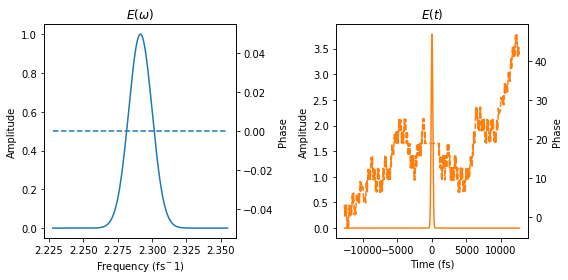

Ew FWHM 0.014099999997486483
Et FWHM 196.2165688191716


In [4]:
#Centre frequency and bandwidth
w0,sigma=w2f(0.822),0.006

#Second and third-order chirp
A2=0
A3=0

#Create laser frequency and time fields
w,Ew=gaussian_pulse(w0,sigma,A=A2,Nsigma=4.5,Nsamples=2**9)
Ew*=np.exp(1j*A3*(w-w0)**3)
t,Et=ifft_pulse(w,Ew*np.exp(-1j*w*0))


#### MAKE PLOTS #####
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax2=ax.copy()

ax[0].set_title(r'$E(\omega)$')
ax[0].plot(w,np.abs(Ew))
ax[0].set_xlabel(r'Frequency (fs$^-1$)')
ax[0].set_ylabel(r'Amplitude')

ax2[0]=ax[0].twinx()
ax2[0].plot(w,np.unwrap(np.angle(Ew)),'C0--')
ax2[0].set_ylabel(r'Phase')

ax[1].set_title(r'$E(t)$')
ax[1].plot(t,np.abs(Et),'C1')
ax[1].set_xlabel(r'Time (fs)')
ax[1].set_ylabel(r'Amplitude')

ax2[1]=ax[1].twinx()
ax2[1].plot(t,np.unwrap(np.angle(Et)),'C1--')
ax2[1].set_ylabel(r'Phase')


plt.tight_layout()
plt.show()

print('Ew FWHM',fit_gaussian((w,np.abs(Ew)**2)).x[2]*2.35)
print('Et FWHM',fit_gaussian((t,np.abs(Et)**2)).x[2]*2.35)

## XFROG Spectrogram

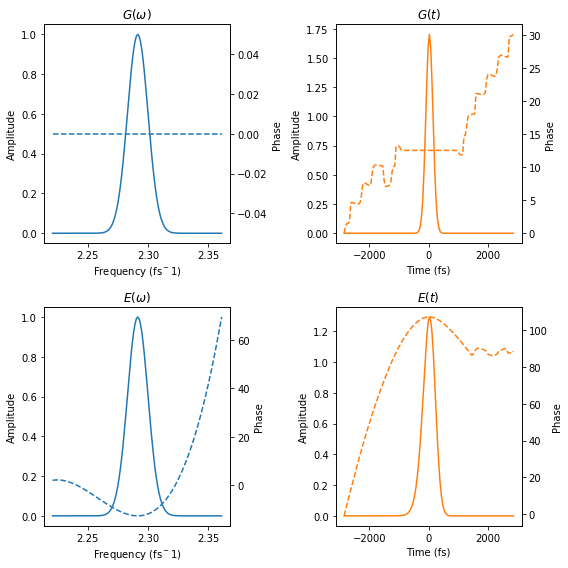

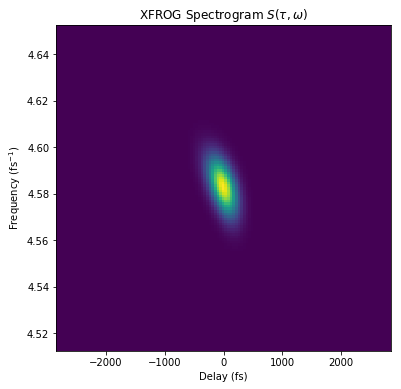

In [5]:
#Center frequency and bandwidth
w0,sigma=w2f(0.822),0.006

#Second and third-order chirp
A2=1e4
A3=1e5

#Define signal field and gate function in frequency
w,Ew=gaussian_pulse(w0,sigma,A=A2,Nsigma=5,Nsamples=128)
w,Gw=gaussian_pulse(w0,sigma,A=0,Nsigma=5,Nsamples=128)
Ew*=np.exp(1j*A3*(w-w0)**3)

#Calculate pulse in time
t,Gt=ifft_pulse(w,Gw)
t,Et=ifft_pulse(w,Ew)

#Calculate signal field
Esig=CalcEsigOuter(Et,Gt)

#Calculate spectrogram
S=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Esig,axes=0),axes=[0]),axes=0)



#### MAKE PLOTS #######
fig,ax=plt.subplots(2,2,figsize=(8,8))
ax=ax.reshape(-1)
ax2=ax.copy()

ax[0].plot(w,np.abs(Gw))
ax2[0]=ax[0].twinx()
ax2[0].plot(w,np.unwrap(np.angle(Gw)),'--')

ax[1].plot(t,np.abs(Gt),'C1')
ax2[1]=ax[1].twinx()
ax2[1].plot(t,np.unwrap(np.angle(Gt)),'C1--')

ax[2].plot(w,np.abs(Ew))
ax2[2]=ax[2].twinx()
ax2[2].plot(w,np.unwrap(np.angle(Ew)),'--')

ax[3].plot(t,np.abs(Et),'C1')
ax2[3]=ax[3].twinx()
ax2[3].plot(t,np.unwrap(np.angle(Et)),'C1--')

ax[0].set_xlabel(r'Frequency (fs$^-1$)')
ax[0].set_title(r'$G(\omega)$')
ax[0].set_ylabel(r'Amplitude')
ax2[0].set_ylabel(r'Phase')

ax[1].set_title(r'$G(t)$')
ax[1].set_xlabel(r'Time (fs)')
ax[1].set_ylabel(r'Amplitude')
ax2[1].set_ylabel(r'Phase')

ax[2].set_xlabel(r'Frequency (fs$^-1$)')
ax[2].set_title(r'$E(\omega)$')
ax[2].set_ylabel(r'Amplitude')
ax2[2].set_ylabel(r'Phase')

ax[3].set_title(r'$E(t)$')
ax[3].set_xlabel(r'Time (fs)')
ax[3].set_ylabel(r'Amplitude')
ax2[3].set_ylabel(r'Phase')

plt.tight_layout()
plt.show()

#Estimating the frequency axis. Is there a better way to do this?
T,W=FROG_grid((2*w0,np.diff(w)[0]),axis=1,n=w.size)

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh(T,W,np.abs(S)**2)
ax.set_title(r'XFROG Spectrogram $S(\tau,\omega)$')
ax.set_xlabel('Delay (fs)')
ax.set_ylabel(r'Frequency (fs$^{-1}$)')
plt.show()


# FROG Simulated Data

Iterations 500
FROG Error 5.395122728541741e-06


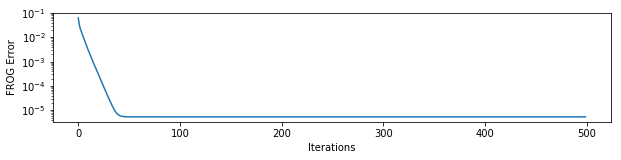

Fidelity 0.9999999720378605


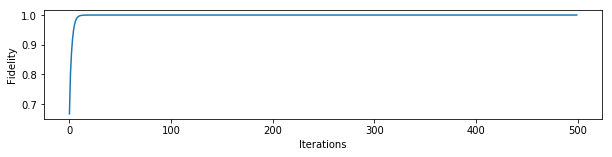

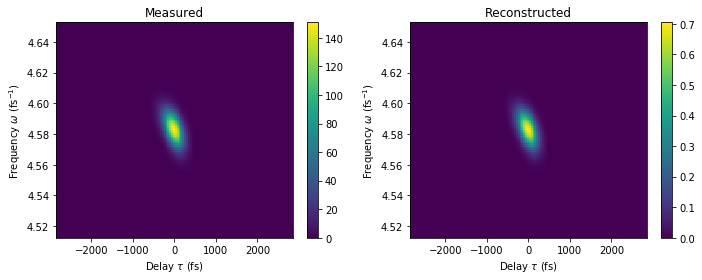

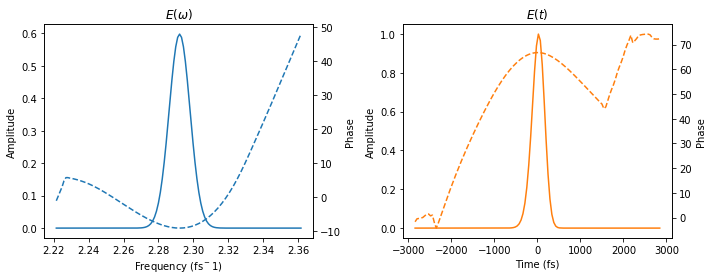

In [6]:
dw=np.diff(w)[0]
k,tk,Etk,wk,Ewk,Gk,Sk,EF=run_PCGP_FROG((T,W,np.abs(S)**2),
                              max_iter=500,type='XFROG',Egate=Gt,initial_guess='random',
                              target_state=(t,Et))


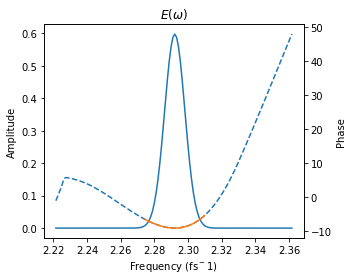

Optimal parameters:  [-9.10896947e+00  4.47570748e-03  9.99784471e+03  9.99780581e+04]


In [7]:
out=fit_phase(wk,Ewk,p0=[1e5,1e4,0,2.29,-10],plot=True,cutoff=0.01)